Ponowne puszczenie kodów dla autoenkodera z podmianką hiperparametrów oraz w drugim kroku zbuduję jednoklasową maszynę wektorów nośnych (OneClass SVM) 

In [1]:
# importujemy pakiety
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K
from keras import regularizers
from imblearn.under_sampling import TomekLinks

#ustawiam ziarno pseudolosowania i udział zbioru testowego
RANDOM_SEED = 128262
TEST_PCT = 0.2

#ustawienia stylu grafik, w tym wypadku wykorzystałem schemat kolorów z xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # złoty podział
LABELS = ["Normal","Fraud"]

# wczytujemy zbiór danych
df = pd.read_csv("creditcard.csv")

In [2]:
#Normalizowanie oraz skalowanie danych, wymagane aby skorzystać z sieci neuronowej.
df_norm = df.copy()
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [3]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column

test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray


In [4]:
print(train_x.shape)

(227448, 30)


In [5]:
# Struktura warstw oraz parametry autoenkodera
nb_epoch =50
batch_size = 128
input_dim = train_x.shape[1] #kolumn mamy w tym wypadku 30
encoding_dim = 18
hidden_dim1 = 10 # typowo dajemy int(encoding_dim / 2)
hidden_dim2 = 6
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ), name='encoder_input')

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)

# dygresja, tworzę modelik enkodera żeby działać na przestrzeni ukrytej
encoder_model = Model(inputs = input_layer, outputs = encoder)


decoder_input = Input(shape=(hidden_dim2,), name='decoder_input')

decoder = Dense(hidden_dim2, activation='elu')(decoder_input)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

decoder_model = Model(inputs=decoder_input, outputs = decoder)

# teraz tworzymy model z warstwą wejściową oraz czterema warstwami gęstymi
auto_input = input_layer
auto_output = decoder_model(encoder)
autoencoder = Model(inputs=auto_input, outputs=auto_output)

# Konfiguracja procesu nauki poprzez skompilowanie modelu
#https://keras.io/api/models/model_training_apis/#compile-method
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Zapisanie modelu


# Ładujemy zbudowany model zbudowany w poprzednim pliku 
autoencoder = load_model('./run/vae/auto_for_fraud/autoencoder_fraud.h5')





In [6]:
from sklearn.svm import SVC

# tworzę wartswę ukrytą i na niej buduję multiklasowy model SVM 
X_svm = encoder_model.predict(test_x)
y_svm = test_y.copy()

print(X_svm.shape)

(56962, 6)


In [7]:
#rozkład zmiennej 
from collections import Counter
print(sorted(Counter(y_svm).items()))

[(0, 56867), (1, 95)]


W tym miejscu skoro nie udało mi się zbudować modelu SVM na rzucie wektora reprezentacji do 2D, spróbuję go zbudować w przestrzenii 6D i ocenić za pomoca macierzy pomyłek (na zbiorze treningowym). 


In [8]:
# granice przestrzeni ukrytej
for i in range(0,6):
    print("wymiar {0}: od {1:.3f} do {2:.3f}".format(i+1, np.min(X_svm[:,i]), np.max(X_svm[:,i])))


wymiar 1: od -0.938 do 0.939
wymiar 2: od -0.993 do 0.897
wymiar 3: od -0.942 do 0.999
wymiar 4: od -0.928 do 0.965
wymiar 5: od -0.964 do 0.988
wymiar 6: od -0.975 do 0.965


Zbiór został znormalizowany więc SVM powinna zadziałać prawidłowo bez dodatkowej normalizacji

In [9]:
# budowanie na pełnym zbiorze danych trwa zbyt długo, działam zatem jedynie na podziborze jaki wygenerowałem do stworzenia wykresu
Cp =1000  #  0.01, 1000
gammap='scale' # 0.1, 1 'scale' ‘auto’
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')  # kerner = {sigmoid, rbf}

svm_model.fit(X_svm, y_svm)



SVC(C=1000, decision_function_shape='ovo')

In [10]:
y_pred = svm_model.predict(X_svm).reshape(y_svm.shape)

In [11]:
from collections import Counter

Counter(y_pred).items()

dict_items([(0, 56896), (1, 66)])

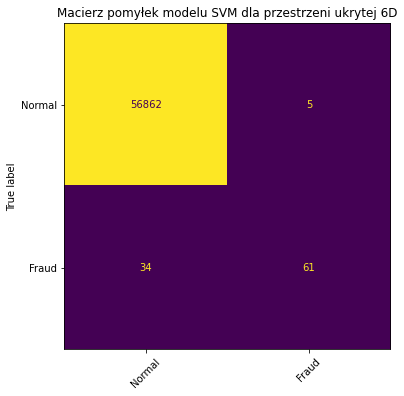

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(figsize=( 12, 6))

cm = confusion_matrix(y_svm, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = LABELS)
disp.plot(ax=axes, xticks_rotation=45)
disp.ax_.set_title("Macierz pomyłek modelu SVM dla przestrzeni ukrytej 6D")
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
plt.savefig("confusion_matrix_c1000_gamma_scale.png", format='png', dpi=300, facecolor="White")


Zadziałało, to może zamiast polegać na organoleptycznej ocenie dopasowania zastosuję przeszukanie siatki

In [21]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[1, 10, 100, 1000, 10000], 'gamma':(0.1, 1, 5, 'scale', 'auto')}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='recall')

clf.fit(X_svm, y_svm)
print(sorted(clf.cv_results_.keys()))


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_gamma', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


In [22]:
print("Optymalny hiperparametr C: ", clf.best_params_['C'])
print("Optymalny hiperparametr gamma: ", clf.best_params_['gamma'])

Optymalny hiperparametr C:  1000
Optymalny hiperparametr gamma:  1


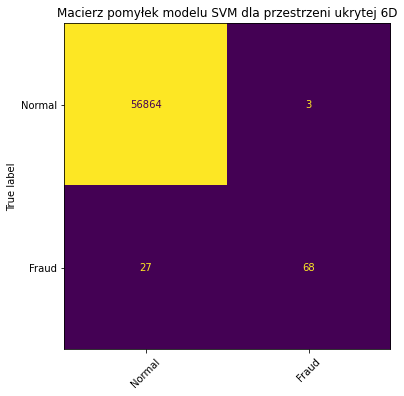

In [17]:
Cp = 1000  #  0.01, 1000
gammap = 1
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')  # kerner = {sigmoid, rbf}

svm_model.fit(X_svm, y_svm)

y_pred = svm_model.predict(X_svm).reshape(y_svm.shape)

f, axes = plt.subplots(figsize=( 12, 6))

cm = confusion_matrix(y_svm, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = LABELS)
disp.plot(ax=axes, xticks_rotation=45)
disp.ax_.set_title("Macierz pomyłek modelu SVM dla przestrzeni ukrytej 6D")
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')

plt.savefig("confusion_matrix_c1000_gamma_1.png", format='png', dpi=300, facecolor="White")

In [20]:
from sklearn.metrics import recall_score, precision_score

print("Recall dla modelu SVM w 6d wynosi {0:.4f}".format(recall_score(y_svm, y_pred)))
print("Precision dla modelu SVM w 6d wynosi {0:.4f}".format(precision_score(y_svm, y_pred)))


Recall dla modelu SVM w 6d wynosi 0.7158
Precision dla modelu SVM w 6d wynosi 0.9577
